# A quick tour of DWave Ocean

In this first notebook we introduce some of the main tools in the Ocean library for programming the Dwave quantum computer. We start with a (very) brief discussion of quantum annealing then move on to introduce two important modules of the Ocean library: the dimod and minorminer modules. At the end of the notebook, useful references that dive deeper in the topics discussed here are presented. 

## Quantum Annealing

The idea behind Quantum Annealing is to map an optimization problem to a Hamiltonian on an Ising lattice of the form

\begin{equation}
H(\mathbf{\sigma}) = -\sum J_{ij}\sigma_{i}\sigma_{j} - \sum h_i\sigma_i, \quad \sigma_i = \pm 1.
\end{equation}

Finding the minimum energy of a general Ising lattice Hamiltonian such as the one above consists in determining the set of $\sigma_i$s that minimize the Hamiltonian $H$. Thus problem is known to be [NP-hard](https://en.wikipedia.org/wiki/NP-hardness). In the mathematical optimization community, discrete unconstrained optimization problems formulated in terms of Ising Hamiltonians are known as Quadratic Unconstrained Optimization problems, or [QUBOs](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization).

Mapping a real world problem into an Ising lattice to be optimized in a DWave computer poses two main theoretical challenges:

- 1. Finding the proper $J$ matrix and $\mathbf{h}$ vector (Energy program);
- 2. Connecting the qubits in the DWave hardware to produce $J$ and $\mathbf{h}$ (Minor embedding).

These two steps appear in the general workflow of quantum adiabatic computation dpicted in the nice picture from the paper <a href= "https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0208561"><i>Open source software in quantum computing</i></a> by Fingerhuth, Babej and Wittek.

<div style="text-align:center"><img src="dwave_workflow.png" >




In this first notebook we shall not be very interested in the nasty details of the theory behind quantum annealers as much as in getting our hands dirty with the Python [Ocean](https://docs.ocean.dwavesys.com) library. In particular we shall focus on two key components of the Ocean suite: the `dimod` and the `minorminer` modules.

## The dimod module

The [dimod](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/index.html) module is the Ocean API for modelling binary quadratic optimization problems. It supports both Ising optimization (where $\sigma_i = \pm 1$) and QUBOs (where $q_i = 0,1$). Let us start with the following QUBO.

\begin{equation}
E(\mathbf{a},B;\mathbf{q}) = \mathbf{a}\cdot\mathbf{q} + B\mathbf{q} = -q_0 - q_1 + 2q_0q_1 
\end{equation}

where we have 
\begin{equation}
\mathbf{a} = (a_0,a_1) = (-1,-1)
\end{equation}
and 
\begin{equation}
B = \begin{bmatrix}
B_{00} & B_{01}\\
B_{10} & B_{11}
\end{bmatrix} = \begin{bmatrix}
0 & 2\\
0 & 0
\end{bmatrix}
\end{equation}

We want to find the binary vector $\mathbf{q} = (q_0,q_1)$ that minimizes $E$. Let us do this with dimod.

In [12]:
import dimod
qubo = dimod.BinaryQuadraticModel({0: -1, 1: -1}, {(0, 1): 2}, 0.0, dimod.BINARY)  
qubo_exact_response = dimod.ExactSolver().sample(qubo)
for sample, energy in qubo_exact_response.data(['sample', 'energy']): 
    print("sample: ", sample, "\t","energy: ", energy)

sample:  {0: 1, 1: 0} 	 energy:  -1.0
sample:  {0: 0, 1: 1} 	 energy:  -1.0
sample:  {0: 0, 1: 0} 	 energy:  0.0
sample:  {0: 1, 1: 1} 	 energy:  0.0


In the code snippet above, we have used the `ExactSolver` sampler to find the energy by brute force of all possible combinations. Evidently, this will quickly become infeasible as the dimensionality of the QUBO grows. So let us investigate what other possible samplers we have. We can use Python's introspection tools to find a little bit more about the `dimod` model. Bellow we print the methods, attributes and functions contained in `dimod`.

In [3]:
", ".join(dir(dimod))

'BINARY, BQM, BinaryPolynomial, BinaryQuadraticModel, BinaryQuadraticModelSizeError, BinaryQuadraticModelStructureError, BinaryQuadraticModelValueError, ComposedPolySampler, ComposedSampler, Composite, ExactSolver, FixedVariableComposite, HigherOrderComposite, InvalidComposition, InvalidSampler, MappingError, NullSampler, PolySampler, PolyScaleComposite, PolyTruncateComposite, RandomSampler, Response, RoofDualityComposite, SPIN, SampleSet, Sampler, ScaleComposite, SimulatedAnnealingSampler, SpinReversalTransformComposite, StructureComposite, Structured, TrackingComposite, TruncateComposite, Vartype, WriteableError, _, __author__, __authoremail__, __builtins__, __cached__, __description__, __doc__, __file__, __loader__, __name__, __package__, __path__, __spec__, __version__, absolute_import, as_samples, as_vartype, binary_quadratic_model, bqm_structured, child_structure_dfs, compatibility23, composite, composites, concatenate, core, decorators, dimod, exact_solver, exceptions, fix_varia

From the list above, we see that several classes like `RandomSampler` and `SimulatedAnnealingSampler` are available for sampling. We can skip Google for a while and again use Python's introspection capabilities to learn a little about the `SimulatedAnnealingSampler` class.

In [ ]:
help(dimod.SimulatedAnnealingSampler)

This is cool, the `SimulatedAnnealingSampler` contains a method `sample` that accepts parameters such as the inverse temperature $\beta$. Let us run this sampler.

In [5]:
qubo_simulated_annealing_response = dimod.SimulatedAnnealingSampler().sample(qubo)
for sample, energy in qubo_simulated_annealing_response.data(['sample', 'energy']): 
    print("sample: ", sample, "energy: ", energy)

sample:  {0: 1, 1: 0} energy:  -1.0
sample:  {0: 1, 1: 0} energy:  -1.0
sample:  {0: 0, 1: 1} energy:  -1.0
sample:  {0: 1, 1: 0} energy:  -1.0
sample:  {0: 0, 1: 1} energy:  -1.0
sample:  {0: 0, 1: 0} energy:  0.0
sample:  {0: 1, 1: 1} energy:  0.0
sample:  {0: 1, 1: 1} energy:  0.0
sample:  {0: 1, 1: 1} energy:  0.0
sample:  {0: 1, 1: 1} energy:  0.0


Note that we got 10 samples, since that is the default value of the `num_reads` parameter. 

Now let us solve the same quadratic optimization problem in the Ising formulation. The QUBO is easily written as an Ising Hamiltonian via the transformation

\begin{equation}
\sigma_i = 2q_i - 1,
\end{equation}

so the corresponding Ising problem is 

\begin{equation}
H(\mathbf{h},\text{J};\mathbf{\sigma}) = -\mathbf{h}\cdot\mathbf{\sigma} - J\mathbf{\sigma} = \frac{1}{2}(\sigma_0\sigma_1 - 1)
\end{equation}

so we have

\begin{equation}
\mathbf{h} = (h_0, h_1) = (0,0)
\end{equation}

and 

\begin{equation}
J = \begin{bmatrix}
J_{00} & J_{01}\\
J_{10} & J_{11}
\end{bmatrix} = \begin{bmatrix}
0 & \frac{1}{2}\\
0 & 0
\end{bmatrix},
\end{equation}

with an offset term of $-\frac{1}{2}$. The code snippet below solves this Ising problem exactly.






In [6]:
ising = dimod.BinaryQuadraticModel({0: 0, 1: 0}, {(0, 1): 0.5}, -0.5, dimod.SPIN)  
ising_exact_response = dimod.ExactSolver().sample(ising)
for sample, energy in ising_exact_response.data(['sample', 'energy']): 
    print("sample: ", sample, "\t", "energy: ", energy)

sample:  {0: 1, 1: -1} 	 energy:  -1.0
sample:  {0: -1, 1: 1} 	 energy:  -1.0
sample:  {0: -1, 1: -1} 	 energy:  0.0
sample:  {0: 1, 1: 1} 	 energy:  0.0


## The minorminer module

The [minorminer](https://docs.ocean.dwavesys.com/projects/minorminer/en/latest/index.html) library is Ocean's tool for minor embedding. The problem of minor embedding consists in finding a map that embeds a minor graph into the target graph. Quoting the Wikipedia article on [minors](https://en.wikipedia.org/wiki/Graph_minor), an undirected graph $H$ is called a minor of the graph $G$ if $H$ can be formed from $G$ by deleting edges and vertices and by contracting edges. This mathematical problem is intimately related to quantum annealing, since the connectivity structure of an optimization problem (the minor) has to be mapped into the connectivity structure of the quantum hardware (the target graph). The `minorminer` implementation is based on the algorithms  Just as we did with the dimod module, let us go through these concepts using the [examples](https://docs.ocean.dwavesys.com/projects/minorminer/en/latest/intro.html#examples) in the documentation.

### Example 1: Embedding the complete triangular graph $K_3$ into a a square target.

This problem is described in the picture below, extracted from Ocean's `minorminer` documentation.

<div style="text-align:center"><img src="Embedding_TriangularSquare.png">



The first triangular graph (the [complete graph](https://en.wikipedia.org/wiki/Complete_graph) $K_3$) is the minor we wish to embed in the square graph in blue. At the rightmost spot, we see such an embedding. Let us perform it using `minorminer`

In [3]:
from minorminer import find_embedding

In [8]:
# Defining graphs
triangle = [(0, 1), (1, 2), (2, 0)]
square = [(0, 1), (1, 2), (2, 3), (3, 0)]

# Find an assignment of sets of square variables to the triangle variables
embedding = find_embedding(triangle, square, random_seed=10)
print(embedding)
# We don't know which variables will be assigned where, here are a
# couple possible outputs:
# [[0, 1], [2], [3]]
# [[3], [1, 0], [2]]


{0: [2, 3], 1: [0], 2: [1]}


We note that we generate a graph in `minorminer` by passing a list of edges (each tuple represents an edge connecting two vertices). The embedding is returned as a Python dictionary. The result printed above is nice and correct, but quite boring. We would be much nicer if we could visualize these graphs somehow. Fortunalety, we can do this using the [dwave_networkx](https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/latest/intro.html) module. This module implements graph theory algorithms optimized for the Chimera and Pegasus architectures used by Dwave quantum computers. Let us visualize a chimera graph.

In [2]:
import dwave_networkx as dnx
import matplotlib.pyplot as plt
connectivity_structure = dnx.chimera_graph(2, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

/home/nahum/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 640x480 with 1 Axes>

When solving a problem on a DWave computer, we shall typically have to embed a given minor graph on a chimera graph like the one above. For example, let us consider the task of embedding the complete graph with nine vertices $K_9$ in the chimera graph above. The $K_9$ graph looks like this.

In [1]:
import networkx as nx
k9 = nx.complete_graph(4)
plt.axis('off') 
nx.draw_networkx(k9, with_labels=False)
plt.show()

NameError: name 'plt' is not defined

We have used Python's `networkx` module (on which Ocean's `dwave_networkx` is based) to visualize the $K_9$ graph. So now let us embed it in the chimera graph!

In [17]:
embedded_k9 = find_embedding(k9.edges(), connectivity_structure.edges(),random_seed=42)
print("embedded_k9: ", embedded_k9)

embedded_k9:  {0: [23, 18], 1: [19, 20], 2: [17], 3: [22]}


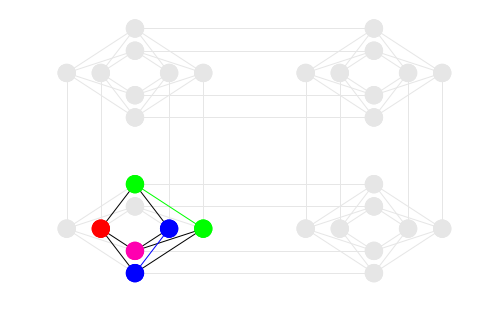

In [18]:
dnx.draw_chimera_embedding(connectivity_structure, embedded_k9)
plt.show()

Note the beautiful color scheme that arises from the embedding. Nodes with the same color in the chimera graph correspond to the same node in the minor (here, the $K_9$ graph). Thus we have nine different colors in the graph above.

One important point to note about these minor embeddings is the length of chains in the embedding. In the DWave hardware, these chains are strong couplings between nodes (twice as strong as the couplings that the user can force on the hardware). Evidently, the longer a chain, the less stable it will be, so embeddings with shorter chains are generally better.


## Embedding a AND gate on d-wave

D-wave does not support natively $K_3$ graphs, so you can not implement a AND gate. In order to do this you have to represent as a penalty model:
\begin{equation}
x_1 x_2 \ -2 (x_1 \ + x_2)x_3 + 3 x_3 
\end{equation}

This penalty model can in turn be represented as the QUBO,
\begin{equation}
E(a_i,b_i;x_i) = 3 x_3 + x_1 x_2 - 2 x_1 x_3 - 2 x_2 x_3
\end{equation}
which is a fully connected K3 graph.
So in order to achieve this we have to do a minor embedding.
<div style="text-align:center"><img src="Embedding_Chimera_AND.png">

We have already found a embedding: 
\begin{equation}
x_1 \rightarrow 0 \ \ \ , \ \ \ x_2 \rightarrow 1 \ \ \ , \ \ \ z \rightarrow (2, 3)
\end{equation}


In [14]:
# Ising problem for a triangular source graph
h = {}
J = {('x1', 'x2'): 1, ('x1', 'z'): -2, ('x2', 'z'): -2, ('z', 'z'): 3}
# Target graph is a square graph
target = nx.cycle_graph(4)

We have to install the dwave system package [dwave-system](https://docs.ocean.dwavesys.com/projects/system/en/latest/intro.html), but this will only work with real d-wave hardware

In [11]:
import dwave
# Embedding from source to target graph
embedding = {'x1': {0}, 'x2': {1}, 'z': {2, 3}}
# Embed the Ising problem
target_h, target_J = dimod.embed_ising(h, J, embedding, target)
target_J[(0, 1)] == J[('a', 'b')]

AttributeError: module 'dimod' has no attribute 'embed_ising'

## Project: Map coloring

In this small project we use the `ocean` module to solve a classical graph problem: [map coloring](https://en.wikipedia.org/wiki/Map_coloring). The [DWave documentation](https://docs.ocean.dwavesys.com/en/latest/examples/map_kerberos.html#map-kerberos) will be our guide.

<img src= "us_map.png">

First we use a .adj file that contains the information of the neighbors of each state

In [90]:
US = nx.read_adjlist('usa.adj', delimiter = ',') 

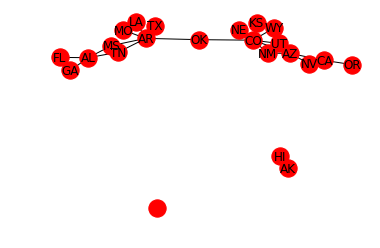

In [91]:
plt.axis('off') 
nx.draw_networkx(US)
plt.show()

Using a CPU: (**It is not recommended to do this**)

In [ ]:
sampler = ExactSolver()
coloring = dnx.min_vertex_coloring(US, sampler, chromatic_ub=4)
set(coloring.values())

Sadly it is not possible to solve this using only a CPU, it is needed a QPU. Using cerberos we have the following code:

In [ ]:
from hybrid.reference.kerberos import KerberosSampler
coloring = dnx.min_vertex_coloring(US, sampler=KerberosSampler(), chromatic_ub=4, max_iter=10, convergence=3)
set(coloring.values())

In [ ]:
node_colors = [coloring.get(node) for node in US.nodes()]
if dnx.is_vertex_coloring(US, coloring):  # adjust the next line if using a different map
   nx.draw(G, pos=nx.shell_layout(US, nlist = [list(US.nodes)[x:x+10] for x in range(0, 50, 10)] + [[list(US.nodes)[50]]]), with_labels=True, node_color=node_colors, node_size=400, cmap=plt.cm.rainbow)
plt.show()

## Square Coloring

We use the `ocean` module to solve Map colloring, since the previous example we were not able to solve because we don't have a QPU.
<img src= "coloring-2.gif">

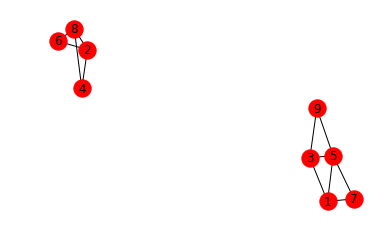

In [9]:
SQ = nx.read_adjlist('Example.adj', delimiter= ',') 
plt.axis('off') 
nx.draw_networkx(SQ)
plt.show()

In [ ]:
from dimod.reference.samplers import ExactSolver
sampler = ExactSolver()
coloring = dnx.min_vertex_coloring(SQ, sampler, chromatic_ub=4)
set(coloring.values())

## Minimum Vertex Cover

A vertex cover is a set of vertices such that each edge of the graph is incident with at least one vertex in the set. A minimum vertex cover is the vertex cover of smallest size. This is a classical Graph problem that is known to be NP Hard. It can be solved using the D-Wave system or using the CPU classical sampler.

### Problem:
Suppose we have a 10 node star graph and we want to know the minimum vertex cover for this graph.

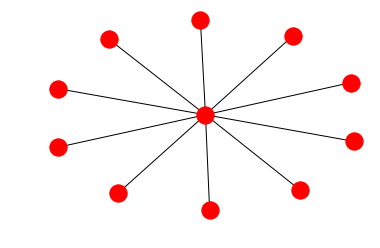

In [80]:
import networkx as nx
s10 = nx.star_graph(10)
plt.axis('off') 
nx.draw_networkx(s10, with_labels=False)
plt.show()

This time we will use our **CPU** to sample and solve the problem

In [81]:
from dimod.reference.samplers import ExactSolver
import dwave_networkx as dnx
sampler = ExactSolver()
print(dnx.min_vertex_cover(s5, sampler))

[0]


Let's solve using the **D-wave system**.

It is used EmbeddingComposite() to do the minor embedding from our graph into the D-wave system

In [ ]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
sampler = EmbeddingComposite(DWaveSampler(endpoint='https://URL_to_my_D-Wave_system/', token='ABC-123456789012345678901234567890', solver='My_D-Wave_Solver'))
print(dnx.min_vertex_cover(s5, sampler))

Let's try to solve a more complicated system

In [83]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5,6])
G.add_edges_from([(1,2),(1,3),(2,3)]) 
G.add_edges_from([(3,4),(3,5),(3,6)])

/home/nahum/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


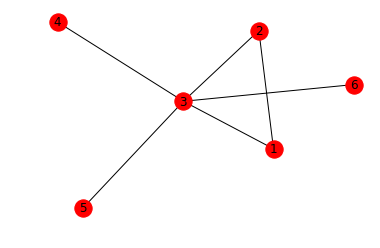

In [84]:
plt.axis('off') 
nx.draw_networkx(G)
plt.show()

In [85]:
sampler = ExactSolver()
print(dnx.min_vertex_cover(G, sampler))

[2, 3]
